# IMPORTS AND VISUALIZATION

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
#from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
#from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline
from nltk.tokenize import word_tokenize
from __future__ import unicode_literals
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import nltk
nltk.download("wordnet")
!pip install hazm
from hazm import *



# Keras
from keras import optimizers
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Embedding, Dropout
from keras.layers import GlobalMaxPool1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import CuDNNLSTM, LSTM, Bidirectional
from keras.layers.convolutional import Conv1D
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package wordnet to /root/nltk_data...


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 316 kB 8.5 MB/s 
     |████████████████████████████████| 1.4 MB 43.3 MB/s 
     |████████████████████████████████| 233 kB 43.2 MB/s 
  Created wheel for nltk: filename=nltk-3.3-py3-none-any.whl size=1394484 sha256=a1a1bda98d525b99da5641c3cb36c0e65b58ba9d91d78ff605c3cd8daa15a8b4
  Stored in directory: /root/.cache/pip/wheels/9b/fd/0c/d92302c876e5de87ebd7fc0979d82edb93e2d8d768bf71fac4
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp37-cp37m-linux_x86_64.whl size=154854 sha256=4430fcfc6a6afb2750af1e9c90002986ffc7855a1bd7c92d5f2d9891b7828ece
  Stored in directory: /root/.cache/pip/wheels/ab/b2/5b/0fe4b8f5c0e65341e8ea7bb3f4a6ebabfe8b1ac31322392dbf
Successfully built nltk libwapiti
  Attempting uninstall: nltk
    Found existing installation: nltk 3.7
    Uninstalling nltk-3.7:
      Successfully uninstalled nltk-3.7


**Read data**

In [91]:
import pandas as pd
df = pd.read_excel("/content/sample_data/dataset for clustering.xlsx")
df

,Comment,Label
0,شهید بهشتی رو انتخاب کردم چون از هر نظر عالیه,3.0
1,بعد از تحقیق بسیار، دقیقا بر اساس اساتید بهشتی...,3.0
2,متاسفانه خیییلی زیاده بی نظمی و اين بده,1.0
3,واقعا من یک نفر توو دانشگاه بهشتی رضایتی ندارم,1.0
4,من از نظم خوابگاه راضي نيستم.,1.0
...,...,...
226,کالا کیفیت غذای سلف اکثر دانشگاه ها راضی کننده...,1.0
227,قوانین موجود در دانشکده کامپیوتر برای دانشجویا...,1.0
228,از غذا، قوانین و رفتار بعضی مسئولین راضی نیستم,1.0
229,رفتار نامناسب از اساتید ندیدم,3.0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,Comment,Label
0,شهید بهشتی رو انتخاب کردم چون از هر نظر عالیه,3.0
1,بعد از تحقیق بسیار، دقیقا بر اساس اساتید بهشتی...,3.0
2,متاسفانه خیییلی زیاده بی نظمی و اين بده,1.0
3,واقعا من یک نفر توو دانشگاه بهشتی رضایتی ندارم,1.0
4,من از نظم خوابگاه راضي نيستم.,1.0


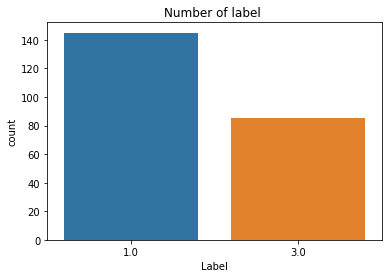

In [92]:
# df = df.dropna(subset = ["Comment"], inplace=True)
sns.countplot(df.Label)
plt.xlabel('Label')
plt.title('Number of label ')

df.head()

# NORMALIZATION

In [93]:
import nltk
nltk.download('omw-1.4')
import re
from nltk.corpus import wordnet
#حذف کاراکتر های تکراری
class RepeatReplacer(object):
    def __init__(self):
        self.repeat_regexp=re.compile(r'(\w*)(\w)\2(\w*)')
        self.repl=r'\1\2\3'
    def replace(self,word):
        if(wordnet.synsets(word)):
            return word
        repl_word=self.repeat_regexp.sub(self.repl,word)
        if(repl_word!=word):
            return self.replace(repl_word)
        else:
            return repl_word


replacer=RepeatReplacer()



def clean(text):
  #حذف الفبای انگلیسی .....حذف ارقام.......حذف کاراکتر های بی استفاده
  unwanted_digit=['0','1','2','3','4','5','6','7','8','9','۰',
                  '۱','۲','٣','۴','۵','۶','۷','۸','۹']#۰۱۲۳۴۵۶۷۸۹
  for digit in unwanted_digit:
    text=text.replace(digit,"")

  unwanted_alpha=['a','b','c','d','e','f','g','h','i','j',
                  'k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
  for alpha in unwanted_alpha:
    text=text.replace(alpha,"")
  
  unwanted_punc=["؟",'،','"',"'",'=','@','&','%','.',',',':','\\','$','^',
                 
                 '<','>','!','?','{','}',';','\n','\t',

                 '(',')','[',']','/','*','+','#','\u200c',

                 '\ufeff','-','_','|',"u200c","\u200c"]
  for punc in unwanted_punc:
    text=text.replace(punc,"")
  return text


#نرمال سازی جملات با استفاده از هضم اصلاح نیم فاصله ها و تبدیل کلمات جمع به حالت مفرد
def normalizeWhazm(text):
  normalizer = Normalizer()
  stemmer = Stemmer()
  lema=Lemmatizer()

  text=normalizer.normalize(text)
  text=lema.lemmatize(text)
  text=stemmer.stem(text)
  return text



def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)



for x in df.index:
    #print(x)
    text = df.loc[x, "Comment"]
    #print(text)
    df.loc[x, "Comment"] = clean(text)
    df.loc[x, "Comment"] = replacer.replace(df.loc[x, "Comment"])
    df.loc[x, "Comment"] = normalizeWhazm(df.loc[x, "Comment"])
    df.loc[x, "Comment"] =remove_emoji(df.loc[x, "Comment"])

    print(df.loc[x, "Comment"])


df.head()

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


شهید بهشتی رو انتخاب کردم چون از هر نظر عالیه
بعد از تحقیق بسیار دقیقا بر اساس اساتید بهشتی رو اول انتخاب کردم چون اساتید بهتر دارد
متاسفانه خیلی زیاده بی نظمی و این بده
واقعا من یک نفر تو دانشگاه بهشتی رضایتی ندار
من از نظم خوابگاه راضی نیس
مسئولان سلب مسئولیت می‌کند و نارضایتی هس
به حقوق دانشجو احترام نمی‌گذارند
بهشتی فقط جاش خوبه بقیش بده
 من از نظر آموزشی و اساتیدی که داشتم به تمام دانشگاهای تهران ترجیحش مید
آموزش برق ک خیلی با ادب و گل و عالی هستن
از نظر اساتید حداقل تو رشته خودم جز دو سه نفرشون قاطع میتونم فقط بگم در جایگاه استادی نیستن و راضی نیستم از ان
عرض کردم از لحاظ آموزشی استادام بهتر هستند نسبت به تمام دانشگاه‌ها تو رشته
ایراد زیاد داره این دانشگاه
حقیقتا منم خیلی از شرایطم راضی ا
از اساتید رضایت دار
امکانات دانشگاه خیلی ضعیف و بد اس
مسیر راه رفتن در دانشگاه سخت است و امکاناتی وجود ندارد
از وضعیت دسترسی و گرفتن کتاب در دانشگاه راضی نیس
من ناراضی هستم از دانشگاه
اینجا مزخرف‌ترین دانگاه هس
همه چی رو به دم تحمیل می‌کند مثل موضوع پایان نامه و این خیلی مزخرفه
دیگه این جا را ان

,Comment,Label
0,شهید بهشتی رو انتخاب کردم چون از هر نظر عالیه,3.0
1,بعد از تحقیق بسیار دقیقا بر اساس اساتید بهشتی ...,3.0
2,متاسفانه خیلی زیاده بی نظمی و این بده,1.0
3,واقعا من یک نفر تو دانشگاه بهشتی رضایتی ندار,1.0
4,من از نظم خوابگاه راضی نیس,1.0


# DELETE STOP WORDS

In [115]:
path2='/content/sample_data/my_stop_words (1).txt'
data = pd.read_csv(path2, header = None)
#در ابتدا هر سطر را توکنایز میکنیم بعد استاپ وورد ها را حذف میکنیم و درون دیتاست قرار میدهیم
def TokDelStopW(text):
  z=[]
  text=word_tokenize(text)

  for i in range(len(text)):
    
    for x in data.index:
      
      if data.loc[x,0] == text[i]:
        z.append(i)
        break
        
  temp=[]
  for j in z:
    temp.append(text[j])
  text = [x for x in text if x not in temp]
  return " ".join(text)
  
for x in df.index: 
  df.loc[x, "Comment"] = TokDelStopW(df.loc[x, "Comment"])
  print(df.loc[x, "Comment"])




شهید انتخاب کردم عالیه
بعد تحقیق بسیار دقیقا اساس اساتید اول انتخاب کردم اساتید
نظمی بده
یک نفر رضایتی ندار
نظم خوابگاه راضی
مسئولان سلب مسئولیت می‌کند نارضایتی
حقوق دانشجو احترام نمی‌گذارند
جاش بقیش بده
آموزشی اساتیدی تمام دانشگاهای تهران ترجیحش مید
آموزش برق ک ادب عالی هستن
اساتید حداقل رشته جز سه نفرشون قاطع میتونم بگم جایگاه استادی نیستن راضی نیستم
عرض کردم لحاظ آموزشی استادام نسبت تمام دانشگاه‌ها رشته
ایراد
حقیقتا منم شرایطم راضی
اساتید رضایت
امکانات ضعیف
مسیر راه رفتن سخت امکاناتی
دسترسی کتاب راضی
ناراضی
مزخرف‌ترین دانگاه
دم تحمیل می‌کند موضوع پایان نامه مزخرفه
دیگه جا انتخاب نمی‌کن
راضی
امکانات ضعیف
رابطه زمان راضی
امکان ورود زمان‌های تعطیل
منطقه خوش اب هوای قرار
مسیر سخته شیب
طریقه اطلاع رسانی نمرات پیشرفته روز
تعداد مناسب رستوران بوفه
ارتباط مناسب صنعت
ازمایشگاه‌های خوبی
اساتید صنعت شرکت‌ها ارتباط
اخلاق برخورد مناسب کارکن
تنوع رابطه گرایش‌ها رشته‌های مختلف
دچرخه فضای
تنوعی غذای سلف
سلف ناراضی
سلف تابستان بسته
شیب تسهیلات مناسب رابطه
نحوه برگزاری کلاس سمینار
تعداد واحد‌های قبل 

In [95]:
df.to_csv('clean_data.csv')

# BILD VOCABULARY

define vocabulary class

In [116]:
#The first thing to do is to create values for our start of sentence,
# end of sentence, and sentence padding special tokens

class Vocabulary:
    PAD_token = 0   # Used for padding short sentences
    SOS_token = 1   # Start-of-sentence token
    EOS_token = 2   # End-of-sentence token

    def __init__(self, name):
        self.name = name
        self.word2index = {}  #a dictionary to hold word token to corresponding word index values
        self.word2count = {}  #a dictionary to hold individual word counts (tokens, actually) in the corpus
        self.index2word = { 0: "PAD", 1: "SOS", 2: "EOS"}  
              #a dictionary holding the reverse of word2index (word index keys to word token values); special tokens added right away
        self.num_words = 3             #this will be a count of the number of words (tokens, actually) in the corpus
        self.num_sentences = 0         # this will be a count of the number of sentences 
                                       #(text chunks of any indiscriminate length, actually) in the corpus
        self.longest_sentence = 0      # this will be the length of the longest corpus sentence by number of tokens

    def add_word(self, word):
        if word not in self.word2index:
                                        # First entry of word into vocabulary
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
                                          # Word exists; increase word count
            self.word2count[word] += 1
            
    def add_sentence(self, sentence):
        sentence_len = 0
        for word in sentence.split(' '):
            sentence_len += 1
            self.add_word(word)
        if sentence_len > self.longest_sentence:
            # This is the longest sentence
            self.longest_sentence = sentence_len
        # Count the number of sentences
        self.num_sentences += 1

    def to_word(self, index):
        return self.index2word[index]

    def to_index(self, word):
        return self.word2index[word]





instantiation a vocabulary class for whole dataset

In [117]:
voc_Doc = Vocabulary('doc')
print(voc_Doc)

In [118]:
for x in df.index:
    #print(x)
    text = df.loc[x, "Comment"]
    print(text)
    voc_Doc.add_sentence(text)

شهید انتخاب کردم عالیه
بعد تحقیق بسیار دقیقا اساس اساتید اول انتخاب کردم اساتید
نظمی بده
یک نفر رضایتی ندار
نظم خوابگاه راضی
مسئولان سلب مسئولیت می‌کند نارضایتی
حقوق دانشجو احترام نمی‌گذارند
جاش بقیش بده
آموزشی اساتیدی تمام دانشگاهای تهران ترجیحش مید
آموزش برق ک ادب عالی هستن
اساتید حداقل رشته جز سه نفرشون قاطع میتونم بگم جایگاه استادی نیستن راضی نیستم
عرض کردم لحاظ آموزشی استادام نسبت تمام دانشگاه‌ها رشته
ایراد
حقیقتا منم شرایطم راضی
اساتید رضایت
امکانات ضعیف
مسیر راه رفتن سخت امکاناتی
دسترسی کتاب راضی
ناراضی
مزخرف‌ترین دانگاه
دم تحمیل می‌کند موضوع پایان نامه مزخرفه
دیگه جا انتخاب نمی‌کن
راضی
امکانات ضعیف
رابطه زمان راضی
امکان ورود زمان‌های تعطیل
منطقه خوش اب هوای قرار
مسیر سخته شیب
طریقه اطلاع رسانی نمرات پیشرفته روز
تعداد مناسب رستوران بوفه
ارتباط مناسب صنعت
ازمایشگاه‌های خوبی
اساتید صنعت شرکت‌ها ارتباط
اخلاق برخورد مناسب کارکن
تنوع رابطه گرایش‌ها رشته‌های مختلف
دچرخه فضای
تنوعی غذای سلف
سلف ناراضی
سلف تابستان بسته
شیب تسهیلات مناسب رابطه
نحوه برگزاری کلاس سمینار
تعداد واحد‌های قبل 

In [119]:
print(f"number of sentences in whole document = {voc_Doc.num_sentences}")
print(f'number of unique word in whole document = {voc_Doc.num_words}')

number of sentences in whole document = 231
number of unique word in whole document = 583


In [120]:
sortedL_doc=sorted(voc_Doc.word2count.items(), key=lambda kv:
                 ( kv[1] , kv[0]))
print(sortedL_doc)

vocab=[ sortedL_doc[i][0]  for i in range(len(sortedL_doc)) ]
vector=[ sortedL_doc[i][1]  for i in range(len(sortedL_doc)) ]

[('آب', 1), ('آدم', 1), ('آشغاله', 1), ('آشنا', 1), ('آمادگی', 1), ('اب', 1), ('اجازه', 1), ('اختصاص', 1), ('اخرش', 1), ('اخلاق', 1), ('اخیرا', 1), ('اداری', 1), ('ادب', 1), ('ادم', 1), ('ارتباطی', 1), ('ارتیاط', 1), ('ازار', 1), ('ازمایشگاهیش', 1), ('ازمایشگاه\u200cها', 1), ('اساتیدبه', 1), ('اساتیدکمک', 1), ('استادام', 1), ('استادی', 1), ('استاد\u200cها', 1), ('استاد\u200cهای', 1), ('اشغال', 1), ('اصلی', 1), ('اعتراض', 1), ('افت', 1), ('افتضاحن', 1), ('افتضاحه', 1), ('افتضاحی', 1), ('افسردگی', 1), ('التحصیل', 1), ('التحصیلی', 1), ('العادست', 1), ('الکی', 1), ('امتح', 1), ('امتحان', 1), ('امتحانا', 1), ('امور', 1), ('امکان', 1), ('امکاناتی', 1), ('انتقادات', 1), ('انشجو', 1), ('انعطاف', 1), ('اهمیتی', 1), ('اول', 1), ('اولی', 1), ('اومدم', 1), ('اون', 1), ('ایراد', 1), ('اینتر', 1), ('اینترنت', 1), ('اینطورین', 1), ('اینقدر', 1), ('اینهمه', 1), ('بارم', 1), ('باسواد', 1), ('باشه', 1), ('باغچه\u200cها', 1), ('باه', 1), ('بخوایم', 1), ('بدردنخور', 1), ('بدن', 1), ('بدک', 1), ('بدی', 1),

**select negative comments and count vocabularies of it**

In [150]:
neg_doc = df.loc[df['Label'] == 1]

neg_doc.to_csv(r'c:\data\negative.txt', header=None, index=None, sep='\t', mode='a')

neg_Doc_v = Vocabulary('neg_doc_v')

for x in neg_doc.index:
    #print(x)
    text = neg_doc.loc[x, "Comment"]
    #print(text)
    neg_Doc_v.add_sentence(text)
neg_doc.head(10)

print(f"number of sentences in whole documents = {neg_Doc_v.num_sentences}")
print(f'number of unique word in whole documents = {neg_Doc_v.num_words}')


sortedL_neg_Doc=sorted(neg_Doc_v.word2count.items(), key=lambda kv:
                 ( kv[1] , kv[0]))


vocab_neg=[ sortedL_neg_Doc[i][0]  for i in range(len(sortedL_neg_Doc)) ]
vector_neg=[ sortedL_neg_Doc[i][1]  for i in range(len(sortedL_neg_Doc)) ]
print(sortedL_neg_Doc)



number of sentences in whole documents = 145
number of unique word in whole documents = 422
[('آدم', 1), ('آشغاله', 1), ('آمادگی', 1), ('اب', 1), ('احترام', 1), ('اخرش', 1), ('اخیرا', 1), ('اداری', 1), ('ادم', 1), ('ارتیاط', 1), ('ازار', 1), ('ازمایشگاه', 1), ('اساتیدبه', 1), ('اساس', 1), ('استاد', 1), ('استادی', 1), ('استاد\u200cها', 1), ('استاد\u200cهای', 1), ('اشغال', 1), ('اصلی', 1), ('اطلاع', 1), ('اعتراض', 1), ('افت', 1), ('افتضاحن', 1), ('افتضاحه', 1), ('افتضاحی', 1), ('افسردگی', 1), ('التحصیل', 1), ('الکی', 1), ('امتح', 1), ('امتحان', 1), ('امتحانا', 1), ('امور', 1), ('امکاناتی', 1), ('انتقادات', 1), ('اندازه', 1), ('انعطاف', 1), ('اهمیتی', 1), ('اولی', 1), ('اومدم', 1), ('اون', 1), ('ایراد', 1), ('اینتر', 1), ('اینترنت', 1), ('اینطورین', 1), ('اینقدر', 1), ('اینهمه', 1), ('بارم', 1), ('باعث', 1), ('بخوایم', 1), ('بدردنخور', 1), ('بدن', 1), ('بدی', 1), ('برخلاف', 1), ('برنامگی', 1), ('بروکراسی', 1), ('برگزاری', 1), ('برگشتنش', 1), ('بریم', 1), ('بستر', 1), ('بسیار', 1), ('بعد',

**select posetive comments and count vocabularis of it**

In [156]:
pos_doc = df.loc[df['Label'] == 3]
pos_doc.to_csv(r'c:\data\posetive.txt', header=None, index=None, sep='\t', mode='a')
df.to_csv(r'c:\data\df.txt', header=None, index=None, sep='\t', mode='a')
pos_Doc_v = Vocabulary('pos_doc_v')

for x in pos_doc.index:
    #print(x)
    text = pos_doc.loc[x, "Comment"]
    #print(text)
    pos_Doc_v.add_sentence(text)
pos_doc.head(10)



print(f"number of sentences in whole document = {pos_Doc_v.num_sentences}")
print(f'number of unique word in whole document = {pos_Doc_v.num_words}')



sortedL_pos_Doc=sorted(pos_Doc_v.word2count.items(), key=lambda kv:
                 ( kv[1] , kv[0]))


vocab_pos=[ sortedL_pos_Doc[i][0]  for i in range(len(sortedL_pos_Doc)) ]
vector_pos=[ sortedL_pos_Doc[i][1]  for i in range(len(sortedL_pos_Doc)) ]
print(sortedL_pos_Doc)

number of sentences in whole document = 85
number of unique word in whole document = 239
[('آب', 1), ('آشنا', 1), ('اجازه', 1), ('احترام', 1), ('اختصاص', 1), ('اخلاق', 1), ('ادب', 1), ('اذیت', 1), ('ارتباطی', 1), ('ارزیابی', 1), ('ارشد', 1), ('ازمایشگاه', 1), ('ازمایشگاهیش', 1), ('ازمایشگاه\u200cها', 1), ('اساتیدکمک', 1), ('اساس', 1), ('استاد', 1), ('استادام', 1), ('اطلاع', 1), ('التحصیلی', 1), ('العادست', 1), ('اموزش', 1), ('امکان', 1), ('انشجو', 1), ('اول', 1), ('ایجاد', 1), ('باسواد', 1), ('باشه', 1), ('باعث', 1), ('باغچه\u200cها', 1), ('باه', 1), ('بدک', 1), ('برا', 1), ('برق', 1), ('برقراری', 1), ('برگزار', 1), ('بزرگ', 1), ('بزرگه', 1), ('بستگی', 1), ('بهتره', 1), ('بهترین', 1), ('بودنشو', 1), ('بوفه\u200cها', 1), ('بپردازد', 1), ('تجربه\u200cهای', 1), ('تحقیقات', 1), ('تخصی', 1), ('ترجیحش', 1), ('تعریف', 1), ('تعطیل', 1), ('تفاوت', 1), ('تمیزه', 1), ('تهران', 1), ('توجه', 1), ('تکنولوژیهای', 1), ('جوان', 1), ('حراست', 1), ('حضور', 1), ('حقیقتا', 1), ('حوزه', 1), ('خاصی', 1), ('خ

**Counting number of unic words in whole dataset, negative and posetive data**

In [123]:
N_Fre_w = vocab[560:]
new_df = pd.DataFrame(dict([  (w,[0,0,0 ])  for w in N_Fre_w ]))
new_df.iloc[0]=[ voc_Doc.word2count[i]  for i in new_df.columns.values.tolist()]


In [124]:
from numpy.ma.core import append

ll=[]
for i in new_df.columns.values.tolist():

  if i not in pos_Doc_v.word2count.keys():
    ll.append(0)
  else:
    ll.append(pos_Doc_v.word2count[i])


new_df.iloc[1]=ll

In [125]:
from numpy.ma.core import append

ll=[]
for i in new_df.columns.values.tolist():

  if i not in neg_Doc_v.word2count.keys():
    ll.append(0)
  else:
    ll.append(neg_Doc_v.word2count[i])


new_df.iloc[2]=ll

In [127]:

new_df

,سخت,شیب,مسئولین,انتخاب,می‌کند,کیفیت,تنوع,غذای,آموزش,فضای,امکانات,سلف,دانشجو‌ها,قوانین,دانشجو,مناسب,دانشجویان,راضی,غذا,اساتید
0,6,6,6,7,7,7,8,8,9,9,10,10,11,11,12,14,15,15,15,40
1,0,0,2,4,2,1,5,1,3,8,5,1,1,0,4,10,7,5,2,21
2,6,6,4,3,5,6,3,7,6,1,5,9,10,10,8,4,8,10,13,19


**Plot distribution of each word in posetive and negative data**

In [128]:
cnt=dict(new_df.loc[1:,"غذا"])

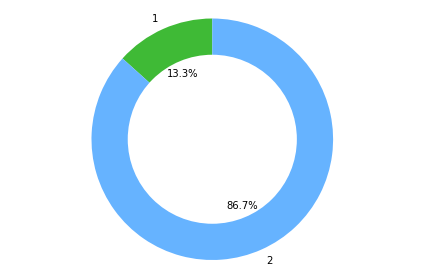

In [129]:
labels = list(cnt.keys())
sizes = list(cnt.values())
colors = ['#3fba36', '#66b3ff','#ffcc99','#ff9999', '#d44444']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
# Decomment following line if you want to save the figure
# plt.savefig('distribution.png')
plt.show()

سخت


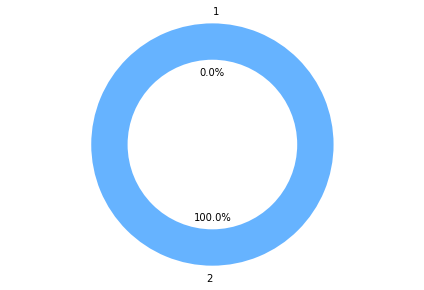

شیب


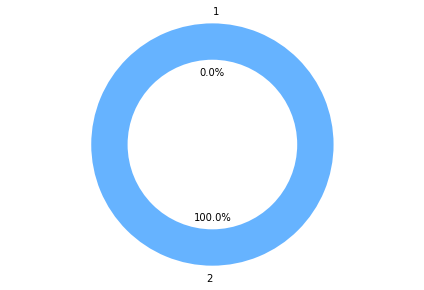

مسئولین


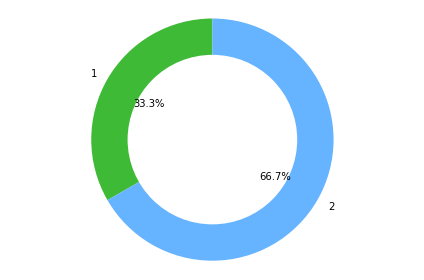

انتخاب


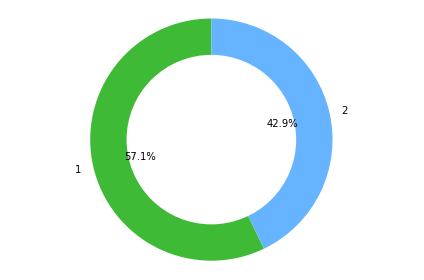

می‌کند


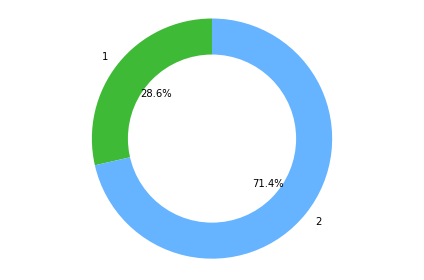

کیفیت


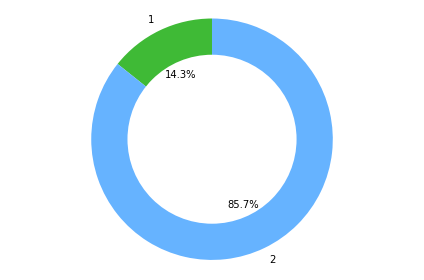

تنوع


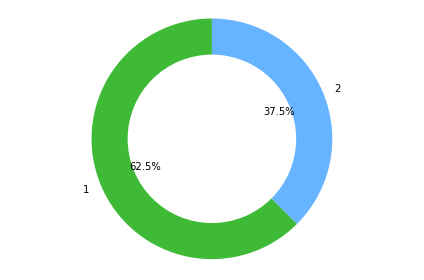

غذای


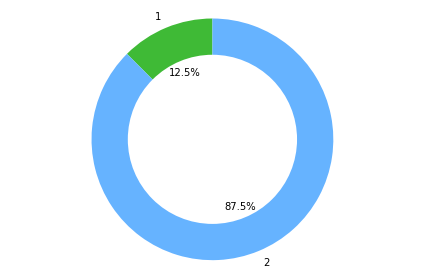

آموزش


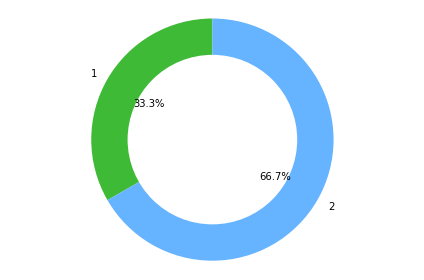

فضای


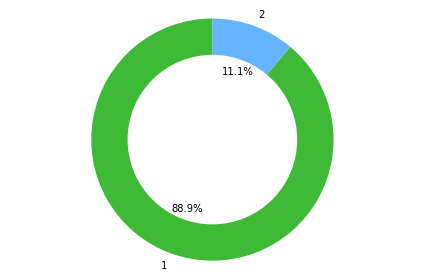

امکانات


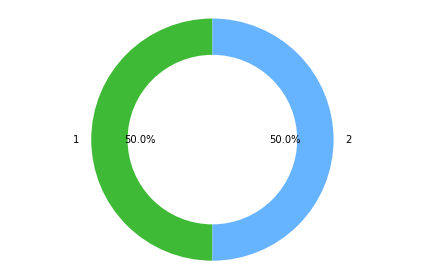

سلف


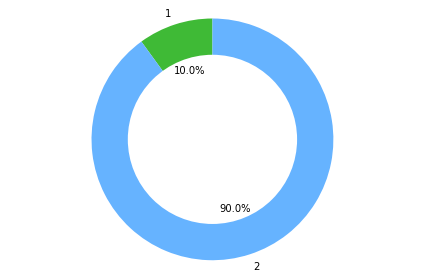

دانشجو‌ها


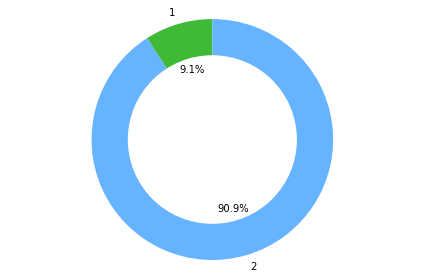

قوانین


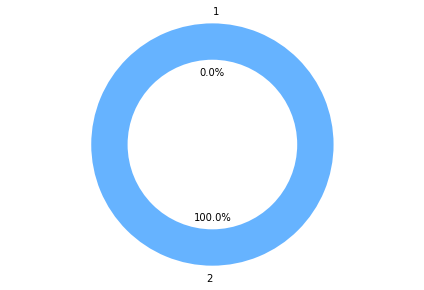

دانشجو


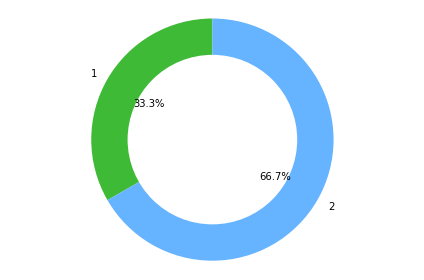

مناسب


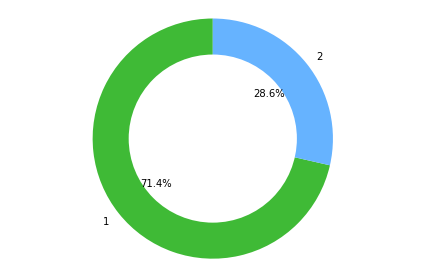

دانشجویان


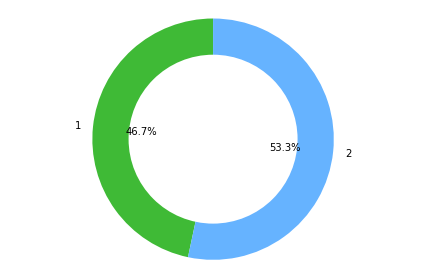

راضی


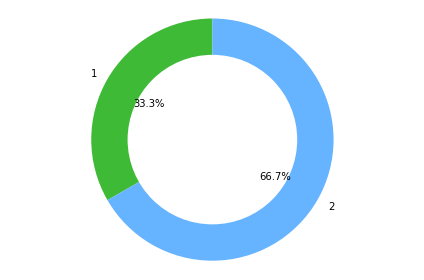

غذا


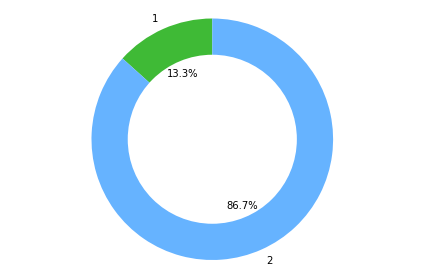

اساتید


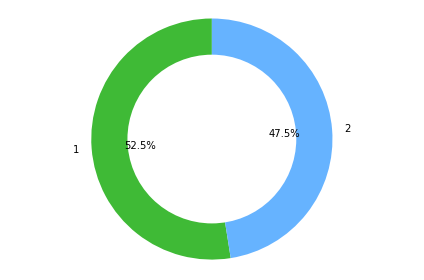

In [130]:
for i in new_df.columns.values.tolist():
  print(i)
  cnt=dict(new_df.loc[1:,i])
  labels = list(cnt.keys())
  sizes = list(cnt.values())
  colors = ['#3fba36', '#66b3ff','#ffcc99','#ff9999', '#d44444']
  fig1, ax1 = plt.subplots()
  ax1.pie(sizes, labels=labels, colors=colors,
          autopct='%1.1f%%', startangle=90)
  #draw circle
  centre_circle = plt.Circle((0,0),0.70,fc='white')
  fig = plt.gcf()
  fig.gca().add_artist(centre_circle)
  # Equal aspect ratio ensures that pie is drawn as a circle
  ax1.axis('equal')  
  plt.tight_layout()
  # Decomment following line if you want to save the figure
  # plt.savefig('distribution.png')
  plt.show()

In [131]:
def BAR_PLOT(X,Y):
  plt.figure(figsize=(40, 10))
  plt.title("frequent word in document ")
  plt.xlabel("Category")
  plt.ylabel("Number of word in document ")
  plt.xticks(rotation=90)
  sns.barplot(X, Y)
  plt.show()


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


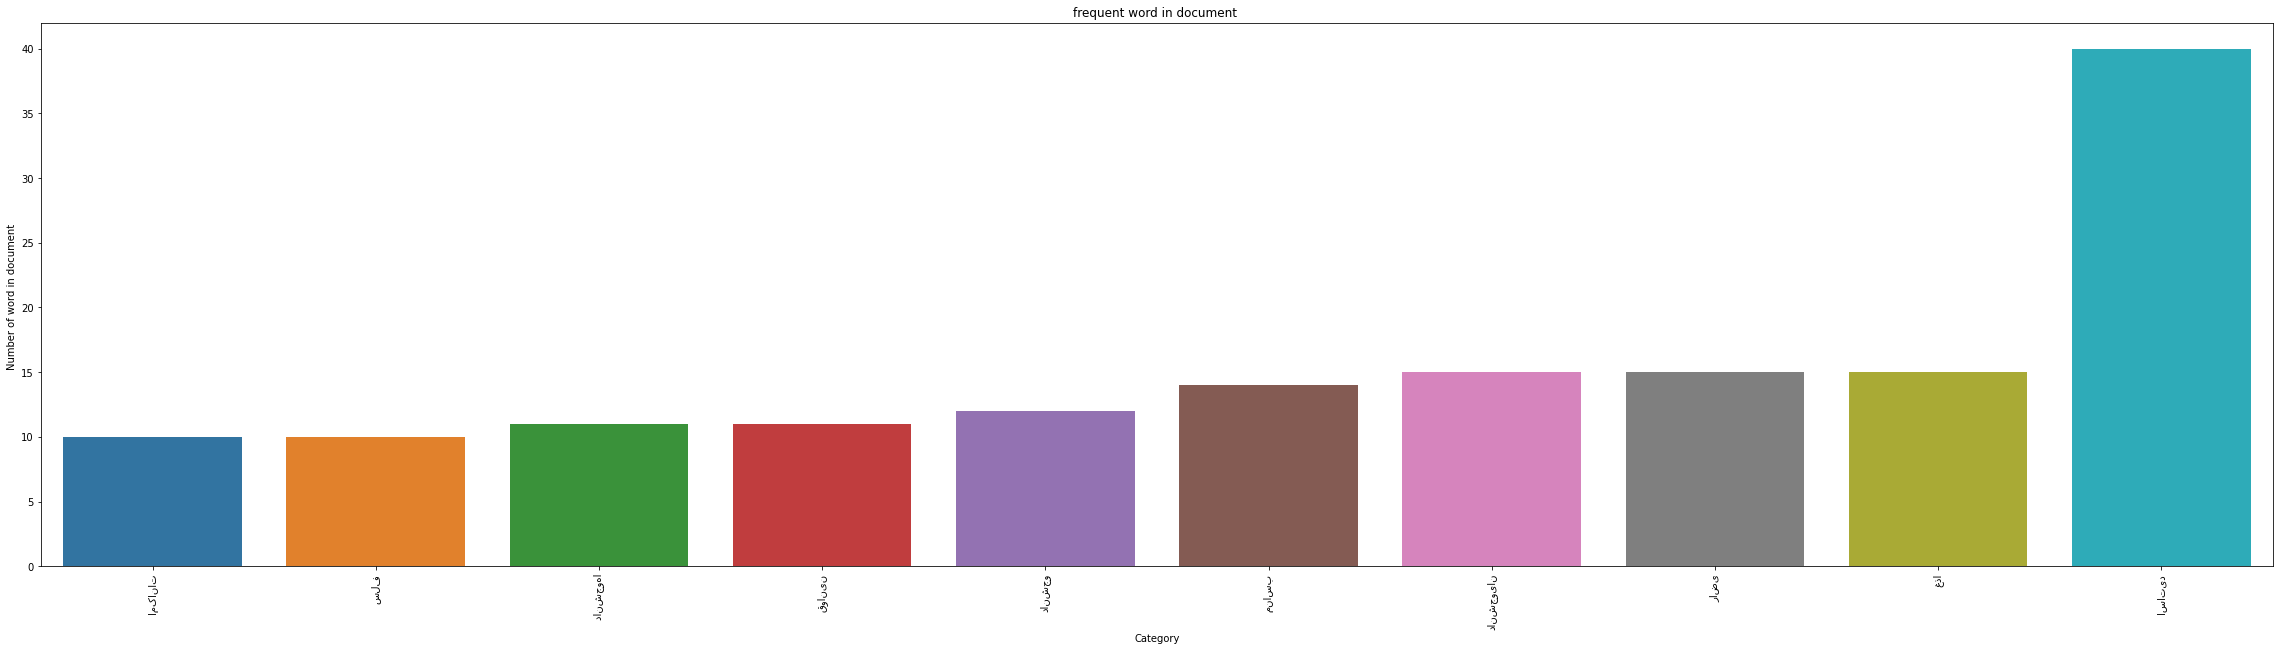

In [134]:
BAR_PLOT(vocab[570:],vector[570:])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


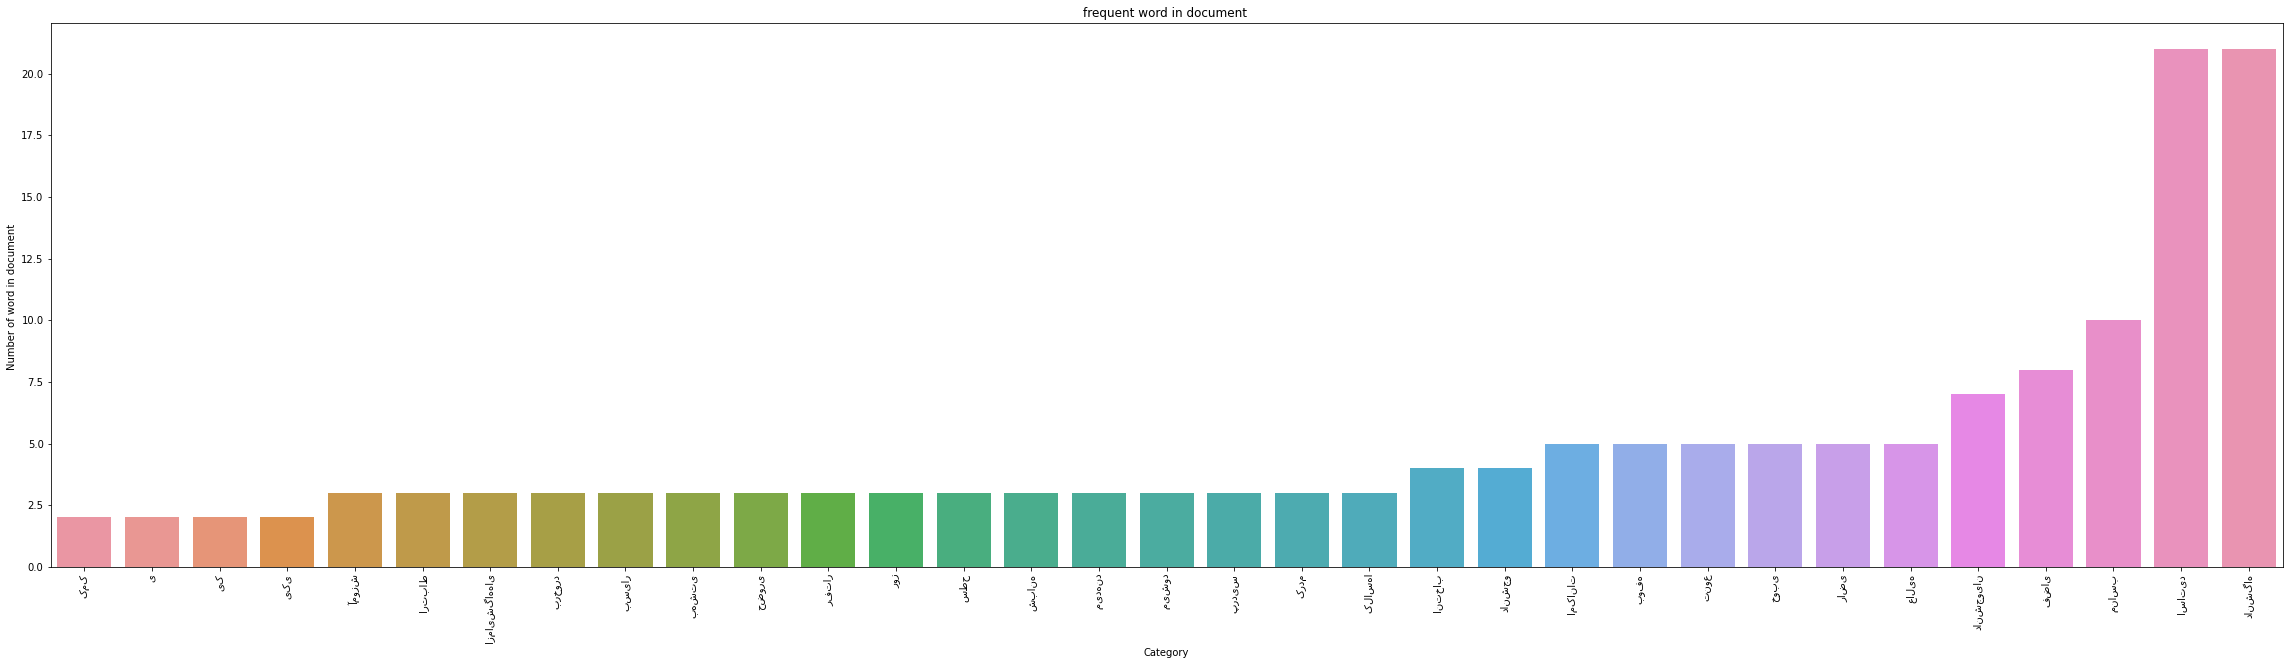

In [86]:
BAR_PLOT(vocab_pos[210:],vector_pos[210:])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


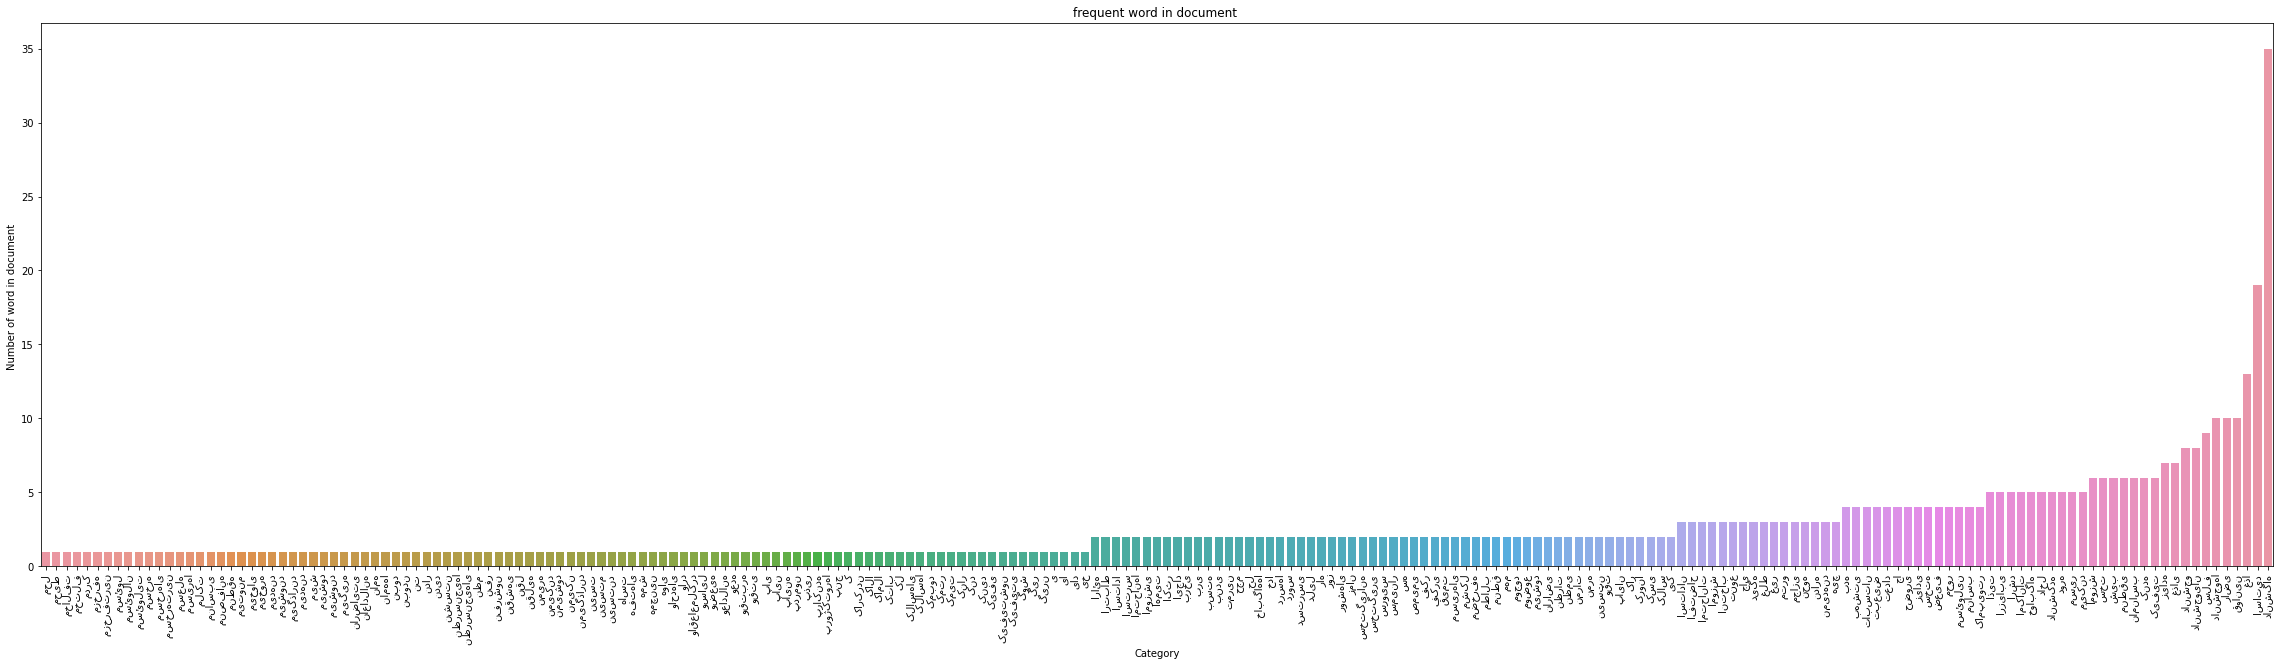

In [90]:
BAR_PLOT(vocab_neg[210:],vector_neg[210:])

**Word** **Clouds**

In [139]:
!pip install persian_wordcloud
!pip install wordcloud-fa
!sudo apt-get install python3-dev

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 3.5 MB/s 
  Created wheel for persian-wordcloud: filename=persian_wordcloud-1.3.1-py3-none-any.whl size=65942 sha256=5cd6ce9ca878abe3f2e9aafdd6e96a6c43a6b37bad10c0a3791bf56b42aab430
  Stored in directory: /root/.cache/pip/wheels/5f/84/30/3f71371632c768bc2a5679e72db807c9b60bc890661f6fbde5
Successfully built persian-wordcloud
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 71 kB 4.9 MB/s 
     |████████████████████████████████| 366 kB 16.1 MB/s 
  Attempting uninstall: wordcloud
    Found existing installation: wordcloud 1.5.0
    Uninstalling wordcloud-1.5.0:
      Successfully uninstalled wordcloud-1.5.0
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-dev is already the newest version (3.6.7-1~18.04

In [161]:
from wordcloud_fa import WordCloudFa

wodcloud = WordCloudFa(no_reshape=False, persian_normalize=True, include_numbers=False, collocations=False, width=800, height=400)

with open('/content/sample_data/c__data_df.txt', 'r') as file:

     text = file.read()



wc = wodcloud.generate(text)
image = wc.to_image()
image.show()
image.save('dfdata.png')

In [162]:
from wordcloud_fa import WordCloudFa

wodcloud = WordCloudFa(no_reshape=False, persian_normalize=True, include_numbers=False, collocations=False, width=800, height=400)

with open('/content/sample_data/c__data_posetive (2).txt', 'r') as file:

     text = file.read()



wc = wodcloud.generate(text)
image = wc.to_image()
image.show()
image.save('posdata.png')

In [158]:
from wordcloud_fa import WordCloudFa

wodcloud = WordCloudFa(no_reshape=False, persian_normalize=True, include_numbers=False, collocations=False, width=800, height=400)
#text = "سلام"
with open('/content/sample_data/c__data_negative (1).txt', 'r') as file:

     text = file.read()

wc = wodcloud.generate(text)
image = wc.to_image()
image.show()
image.save('negdata.png')

**TFIDF**

In [144]:
#Define a function to calculate Term Frequency
#Term Frequency
def termfreq(document, word):
    
    N = len(document.split())
    #print(N)
    occurance = len([token for token in document.split() if token == word])
    return occurance/N

In [145]:
#Inverse Document Frequency
#Define a function calculate Inverse Document Frequency         neg_Doc_v.word2count
def inverse_doc_freq(word,doc):
    try:
        word_occurance = doc.word2count[word] + 1
    except:
        word_occurance = 1
    return np.log(doc.num_sentences/word_occurance)

In [146]:
#Combining the TF-IDF functions

def tf_idf(sentence,doc):
    tf_idf_vec = np.zeros((doc.num_words,))
    for word in sentence.split():
        tf = termfreq(sentence,word)
        idf = inverse_doc_freq(word,doc)
         
        value = tf*idf
        tf_idf_vec[doc.word2index[word]] = value 
    return tf_idf_vec

In [147]:
#Apply the TF-IDF Model to our text
#TF-IDF Encoded text corpus     df.index         df.loc[x, "Comment"]
vectors = []
for x in df.index :
    vec = tf_idf(df.loc[x, "Comment"],voc_Doc)
    vectors.append(vec)
 
print(vectors[40])
print(len(vectors))

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         